In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybedtools import BedTool
import pysam
import glob
from operator import itemgetter
from collections import defaultdict
import os
from plotting_utils import label_sample
from multiprocessing import Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#%%bash
#
#REF_PATH=/stor/work/Lambowitz/ref/hg19
#zcat $REF_PATH/genome/rmsk.bed.gz | grep 'TTAGGG\|CCCTAA' > $REF_PATH/new_genes/TERRA.bed

In [51]:
def define_strand(terra_strand, aln):
    strand = ''
    sense_terra_positive = not aln.is_reverse and terra_strand == "forward"
    sense_terra_negative = aln.is_reverse and terra_strand == '-'
    
    if sense_terra_positive or sense_terra_negative:
        strand = 'Sense'
    else:
        strand = "Antisense"
    return strand
    
def dict_to_df(terra_dict):
    ds = []
    for terra_strand, d1 in terra_dict.items():
        for express_strand, d2 in d1.items():
            ds.append(pd.DataFrame({'isize': list(d2.keys()),
                         'count': list(d2.values())}) \
                        .assign(express_strand = express_strand,
                               terra_strand = terra_strand))
    return pd.concat(ds)
    
def extract_terra_length(bam):
    samplename = os.path.basename(bam)
    print('Running %s' %samplename)
    
    terra_bed = '/stor/work/Lambowitz/ref/hg19/new_genes/TERRA.bed'
    terra_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    pair_count = 0
    with open(terra_bed) as bed, pysam.Samfile(bam,'rb') as bam:
        for terra in bed:
            fields = terra.split('\t')
            chrom, start, end, name = itemgetter(0,1,2,3)(fields)
            terra_strand = 'forward' if 'TTAGGG' in name else 'reverse'
            start, end = int(start), int(end)
            
            for aln in bam.fetch(chrom, start, end):
                if aln.is_read1:
                    express_strand = define_strand(terra_strand, aln)
                    isize = aln.template_length
                    terra_dict[terra_strand + '_' + name][express_strand][abs(isize)] += 1
                pair_count += 1
    print('%s: %i TERRA fragments' %(samplename, pair_count))
    return dict_to_df(terra_dict) \
        .assign(samplename = samplename)

In [52]:
project_path = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map'
bam_path = project_path + '/merged_bam'
bam_files = map(lambda x: bam_path + '/' + x, ['unfragmented.bam',
                                               'alkaline_hydrolysis.bam',
                                               'untreated.bam'])
p = Pool(24)
dfs = p.map(extract_terra_length, bam_files)
p.close()
p.join()

Running unfragmented.bam
Running alkaline_hydrolysis.bam
Running untreated.bam
unfragmented.bam: 2503 TERRA fragments
untreated.bam: 2467 TERRA fragments
alkaline_hydrolysis.bam: 2646 TERRA fragments


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


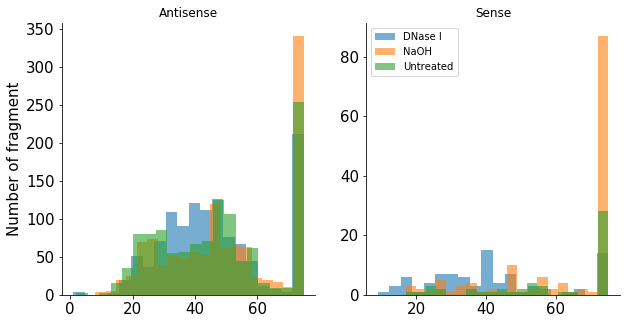

In [53]:
terra_df = pd.concat(dfs) \
    .assign(isize = lambda d: np.where(d.isize > 75, 75, d.isize))\
    .assign(samplename = lambda d: d.samplename.str.replace('.bam','').map(label_sample))\
    .groupby(['samplename','express_strand','isize'], as_index=False)\
    .agg({'count': 'sum'})\
    .sort_values('isize')

fig = plt.figure(figsize=(10,5))

for i, (strand, strand_df) in enumerate(terra_df.groupby('express_strand')):
    ax = fig.add_subplot(1,2,i+1)
    for sample, sample_df in strand_df.groupby('samplename'):
        ax.hist(sample_df.isize, 
                weights = sample_df['count'], 
                label = sample,
                bins=20,
               alpha = 0.6)
        
    if i == 0:
        ax.set_ylabel('Number of fragment')
    ax.set_title(strand)
ax.legend(title='')
sns.despine()